(456, 1, 9675)


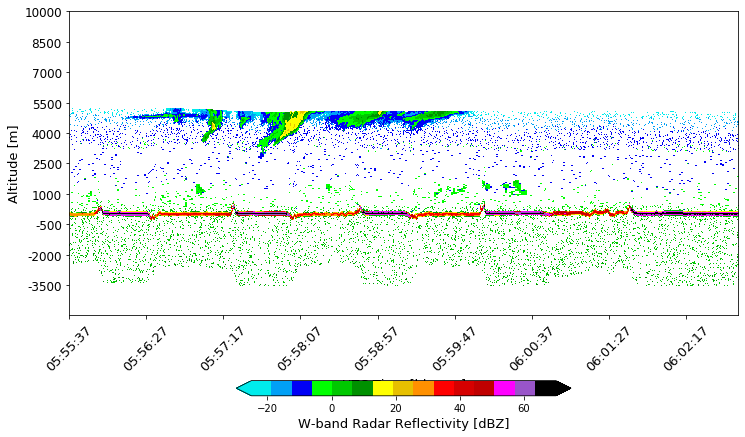

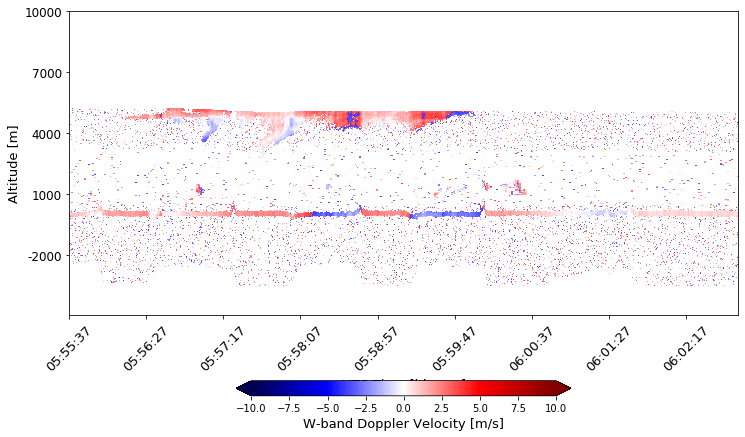

In [23]:
import h5py
import math
import glob
import datetime
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.colors as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from metpy.plots import ctables

def roundup(x):
    for i in range(len(x)):
        x[i] = int(math.ceil(x[i] / 100.0)) * 100 
    return x

ht_gridded = np.linspace(10000.,-5000.,500)
# df = pd.DataFrame(columns=['Lat', 'Lon', 'CTH (km)'])
start = 1000
end = 10000


def grid_altitude(alt3D, W_refl, vel):
    z_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    z_gridded[:,:] = np.nan
    v_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    v_gridded[:,:] = np.nan
    for i in range(np.shape(alt3D)[1]):
        ht = alt3D[:,i]
        z = W_refl[:,i]
        v = vel[:,i]
        for j in range(len(ht)):
            if(np.isnan(z[j])==False and ht[j]>-5000. and ht[j]<10000.):
                m = int((10000.-ht[j])/30.)
                z_gridded[m,i] = z[j]
                v_gridded[m,i] = v[j]
    return z_gridded, v_gridded

# READ AND PARSE HERE
cmap = ctables.registry.get_colortable('NWSReflectivity')

Wn_files = sorted(glob.glob('F:/CAMP2Ex_analysis/DATA/RF07/APR3/*Wn.h5'))
# print(Wn_files[3])
hdf = h5py.File(Wn_files[24], 'r')

#print out the groups of variables
# print("Keys: %s" % hdf.keys())
# Keys: <KeysViewHDF5 ['hi2lo', 'hires', 'lores', 'params_W', 'postEng_cal']>

params_W = hdf['params_W']
#print out the variables within params_W
# for key in params_W.keys():
#      print(key, params_W[key][:])

hires = hdf['hires']
#print out the variables within geolocation
# for key in hires.keys():
#      print(key)

lat = hires['lat'][0,:]
lon = hires['lon'][0,:]
p_vel = hires['gsp_mps'][0,:]

W_refl = hires['z95n']
# print(W_refl.shape)
W_refl_ = W_refl[:,0,start:end]

vel = hires['vel95n']
vel_ = vel[:,0,start:end]

alt3D = hires['alt3D']
print(alt3D.shape)
alt3D_ = alt3D[:,0,start:end]
z_gridded, v_gridded = grid_altitude(alt3D_,W_refl_,vel_)

alt_nav = hires['alt_nav'][0,:]

time = hires['scantime']
time = time[:,start:end]
UTC = []
for i in range(time.shape[1]):
    UTC = np.append(UTC,datetime.datetime.utcfromtimestamp(time[0,i]).strftime('%H:%M:%S'))

# cols = ['UTC', 'Lat', 'Lon', 'Plane speed', 'CTH (m)', 'Plane_Alt(m)', 'Max Reflectivity', 'Max Dop Vel']
# annot = np.zeros((len(lat),2))
# lst = []
# z_gridded = z_gridded[np.where(np.logical_and(ht_gridded>-500.,ht_gridded<8000.))[0][:],:]
# v_gridded = v_gridded[np.where(np.logical_and(ht_gridded>-500.,ht_gridded<8000.))[0][:],:]
# ht_gridded = ht_gridded[np.where(np.logical_and(ht_gridded>-500.,ht_gridded<8000.))[0][:]]
# for shot in range(len(lat)-1):
#     z2 = z_gridded[np.isnan(z_gridded[:,shot])==False,shot] 
#     ht2 = ht_gridded[np.isnan(z_gridded[:,shot])==False] 
#     cth = ht2[np.where(z2>-15.)][0]
#     if (alt_nav[shot]-cth>500.):
#         if (cth>1000.):
# #                 print(shot, cth )
#                 annot[shot,0] = shot
#                 annot[shot,1] = np.where(abs(ht_gridded-cth)==np.min(abs(ht_gridded-cth)))[0]
#                 lst.append([UTC[shot], lat[shot], lon[shot], p_vel[shot], cth, alt_nav[shot],
#                            np.nanmax(z_gridded[:,shot]), v_gridded[np.where(abs(v_gridded[:,shot])==
#                                                                     np.nanmax(abs(v_gridded[:,shot])))[0],shot][0]])
#         else:
#                 annot[shot,:] = np.nan
#                 lst.append([UTC[shot], lat[shot], lon[shot], p_vel[shot], np.nan, alt_nav[shot], np.nan, np.nan])
#     else:
#         annot[shot,:] = np.nan
#         lst.append([UTC[shot], lat[shot], lon[shot], p_vel[shot], np.nan, alt_nav[shot], np.nan, np.nan])
# df = pd.DataFrame(lst, columns=cols)  

plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(z_gridded, cmap=cmap, norm=Normalize(-25,70), interpolation='nearest', aspect='auto')
plt.xlabel('UTC Time [hh:mm]', fontsize=13)
plt.ylabel('Altitude [m]', fontsize=13)
cb = plt.colorbar(shrink=0.5, orientation='horizontal', pad=0.15, extend='both')
cb.ax.set_xlabel('W-band Radar Reflectivity [dBZ]', fontsize=13)

# Set the x-ticks to be UTC Time [hh:mm]
x_ticks = np.arange(UTC.shape[0])
x_labels = [timestamps for timestamps in UTC]
ax.set_xticks(x_ticks[::1000])
ax.set_xticklabels(x_labels[::1000], fontsize=13, rotation=45)

# Set the y-ticks to be height.
vert_vals = ht_gridded
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::50])
ax.set_yticklabels(roundup(vert_vals[::50]).astype(int), fontsize=12)

# for i in range(0,np.shape(annot)[0]):
#     if (np.isnan(annot[i,0])==False):
#         plt.annotate('+', xy=(int(annot[i,0]),int(annot[i,1])), color='k', fontsize=12, weight='bold')
# plt.savefig('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_Wn_Refl_RF07_0533_0538.png', 
#             dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(v_gridded, cmap='seismic', norm=Normalize(-10,10), interpolation='nearest', aspect='auto')
plt.xlabel('UTC Time [hh:mm]', fontsize=13)
plt.ylabel('Altitude [m]', fontsize=13)
cb = plt.colorbar(shrink=0.5, orientation='horizontal', pad=0.15, extend='both')
cb.ax.set_xlabel('W-band Doppler Velocity [m/s]', fontsize=13)

# Set the x-ticks to be UTC Time [hh:mm]
x_ticks = np.arange(UTC.shape[0])
x_labels = [timestamps for timestamps in UTC]
ax.set_xticks(x_ticks[::1000])
ax.set_xticklabels(x_labels[::1000], fontsize=13, rotation=45)

# Set the y-ticks to be height.
vert_vals = ht_gridded
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::100])
ax.set_yticklabels(roundup(vert_vals[::100]).astype(int), fontsize=12)

# plt.savefig('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_Wn_Refl_Velocity_RF07_0533_0538.png', 
#             dpi=400, bbox_inches='tight')
plt.show()

(456, 1, 9675)
['05:58:32' '05:58:32' '05:58:32' '05:58:32' '05:58:32' '05:58:33'
 '05:58:33' '05:58:33' '05:58:33' '05:58:33' '05:58:33' '05:58:33'
 '05:58:33' '05:58:33' '05:58:33' '05:58:33' '05:58:33' '05:58:33'
 '05:58:33' '05:58:33' '05:58:33' '05:58:33' '05:58:33' '05:58:33'
 '05:58:33' '05:58:34' '05:58:34' '05:58:34' '05:58:34' '05:58:34']


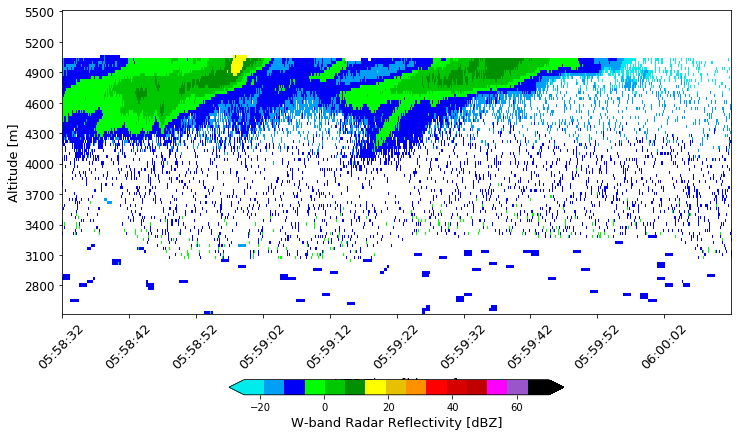

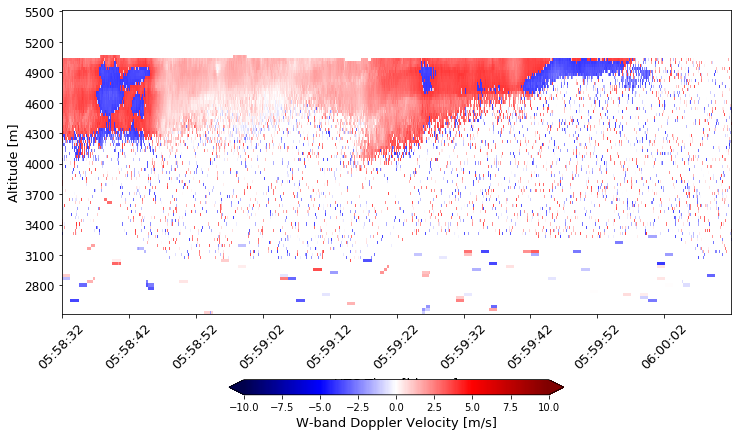

In [38]:
import h5py
import math
import glob
import datetime
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.colors as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from metpy.plots import ctables

def roundup(x):
    for i in range(len(x)):
        x[i] = int(math.ceil(x[i] / 100.0)) * 100 
    return x

ht_gridded = np.linspace(10000.,-5000.,500)
# df = pd.DataFrame(columns=['Lat', 'Lon', 'CTH (km)'])
start = 4500
end = 6500


def grid_altitude(alt3D, W_refl, vel):
    z_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    z_gridded[:,:] = np.nan
    v_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    v_gridded[:,:] = np.nan
    for i in range(np.shape(alt3D)[1]):
        ht = alt3D[:,i]
        z = W_refl[:,i]
        v = vel[:,i]
        for j in range(len(ht)):
            if(np.isnan(z[j])==False and ht[j]>-5000. and ht[j]<10000.):
                m = int((10000.-ht[j])/30.)
                z_gridded[m,i] = z[j]
                v_gridded[m,i] = v[j]
    return z_gridded, v_gridded

# READ AND PARSE HERE
cmap = ctables.registry.get_colortable('NWSReflectivity')

Wn_files = sorted(glob.glob('F:/CAMP2Ex_analysis/DATA/RF07/APR3/*Wn.h5'))
# print(Wn_files[3])
hdf = h5py.File(Wn_files[24],'r')


params_W = hdf['params_W']

hires = hdf['hires']
#print out the variables within geolocation
# for key in hires.keys():
#      print(key)

lat = hires['lat'][0,:]
lon = hires['lon'][0,:]
p_vel = hires['gsp_mps'][0,:]

W_refl = hires['z95n']
# print(W_refl.shape)
W_refl_ = W_refl[:,0,start:end]

vel = hires['vel95n']
vel_ = vel[:,0,start:end]

alt3D = hires['alt3D']
print(alt3D.shape)
alt3D_ = alt3D[:,0,start:end]
z_gridded, v_gridded = grid_altitude(alt3D_,W_refl_,vel_)

alt_nav = hires['alt_nav'][0,:]

time = hires['scantime']
time = time[:,start:end]
UTC = []
for i in range(time.shape[1]):
    UTC = np.append(UTC,datetime.datetime.utcfromtimestamp(time[0,i]).strftime('%H:%M:%S'))   
# print(UTC[15:45])
plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(z_gridded[150:250,:], cmap=cmap, norm=Normalize(-25,70), interpolation='nearest', aspect='auto')
plt.xlabel('UTC Time [hh:mm]', fontsize=13)
plt.ylabel('Altitude [m]', fontsize=13)
cb = plt.colorbar(shrink=0.5, orientation='horizontal', pad=0.15, extend='both')
cb.ax.set_xlabel('W-band Radar Reflectivity [dBZ]', fontsize=13)

# Set the x-ticks to be UTC Time [hh:mm]
x_ticks = np.arange(UTC.shape[0])
x_labels = [timestamps for timestamps in UTC]
ax.set_xticks(x_ticks[::200])
ax.set_xticklabels(x_labels[::200], fontsize=13, rotation=45)

# Set the y-ticks to be height.
vert_vals = ht_gridded[150:250]
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::10])
ax.set_yticklabels(roundup(vert_vals[::10]).astype(int), fontsize=12)

# plt.savefig('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_Wn_Refl_RF07_0558_0600_zoomed.png', 
#             dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(v_gridded[150:250], cmap='seismic', norm=Normalize(-10,10), interpolation='nearest', aspect='auto')
plt.xlabel('UTC Time [hh:mm]', fontsize=13)
plt.ylabel('Altitude [m]', fontsize=13)
cb = plt.colorbar(shrink=0.5, orientation='horizontal', pad=0.15, extend='both')
cb.ax.set_xlabel('W-band Doppler Velocity [m/s]', fontsize=13)

# Set the x-ticks to be UTC Time [hh:mm]
x_ticks = np.arange(UTC.shape[0])
x_labels = [timestamps for timestamps in UTC]
ax.set_xticks(x_ticks[::200])
ax.set_xticklabels(x_labels[::200], fontsize=13, rotation=45)

# Set the y-ticks to be height.
vert_vals = ht_gridded[150:250]
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::10])
ax.set_yticklabels(roundup(vert_vals[::10]).astype(int), fontsize=12)

# plt.savefig('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_Wn_Refl_Velocity_RF07_0558_0600_zoomed.png', 
#             dpi=400, bbox_inches='tight')
plt.show()

In [2]:
# import necessary modules 

%matplotlib inline 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.io import netcdf
import math as math
import netCDF4
from netCDF4 import Dataset,num2date,date2num

directory_P3 = 'C:/Users/arkam/Box/Puja And Arka/Data/'
filename_P3 = directory_P3+'camp2ex-mrg1_p3b_20190908_RA_20200322T172757.ict'

# Read in P3 file

df_P3 = pd.read_csv(filename_P3, delimiter = ',',skiprows=150, names = ['Time_Start','Time_Stop', 'Day_Of_Year', 'Latitude', 'Longitude', 
            'Pressure_Altitude','True_Air_Speed', 'Static_Air_Temp','Dew_Point','Static_Pressure', 'Wind_Speed', 'Wind_Direction',
            'Solar_Zenith_Angle','Mixing_Ratio', 'Part_Press_Water_Vapor', 'Sat_Vapor_Press_H2O', 'Sat_Vapor_Press_Ice', 'Relative_Humidity',
            'H2O_DLH_CAMP2EX-DLH-H2O', 'RHi_DLH_CAMP2EX-DLH-H2O', 'RHw_DLH_CAMP2EX-DLH-H2O', 'H2O_DLH_CAMP2EX-DLH-H2O-20Hz', 'RHi_DLH_CAMP2EX-DLH-H2O-20Hz', 'RHw_DLH_CAMP2EX-DLH-H2O-20Hz',
            'conc_LAWSON', 'ext_LAWSON', 'lwc_LAWSON', 'sv_LAWSON', 'CNT_LAWSON', 
            'cbin01_LAWSON','cbin02_LAWSON','cbin03_LAWSON', 'cbin04_LAWSON','cbin05_LAWSON','cbin06_LAWSON','cbin07_LAWSON',
            'cbin08_LAWSON','cbin09_LAWSON','cbin10_LAWSON','cbin11_LAWSON','cbin12_LAWSON','cbin13_LAWSON','cbin14_LAWSON',
            'cbin15_LAWSON','cbin16_LAWSON','cbin17_LAWSON','cbin18_LAWSON','cbin19_LAWSON','cbin20_LAWSON','cbin21_LAWSON',
            'nbin01_LAWSON','nbin02_LAWSON','nbin03_LAWSON','nbin04_LAWSON','nbin05_LAWSON','nbin06_LAWSON','nbin07_LAWSON',
            'nbin08_LAWSON','nbin09_LAWSON','nbin10_LAWSON','nbin11_LAWSON','nbin12_LAWSON','nbin13_LAWSON','nbin14_LAWSON',
            'nbin15_LAWSON','nbin16_LAWSON','nbin17_LAWSON','nbin18_LAWSON','nbin19_LAWSON','nbin20_LAWSON','nbin21_LAWSON',
            'conc_LAWSON_Hawk','ext_LAWSON_Hawk','lwc_LAWSON_Hawk', 'sv_LAWSON_Hawk', 'CNT_LAWSON_Hawk',
            'cbin01_LAWSON_Hawk','cbin02_LAWSON_Hawk','cbin03_LAWSON_Hawk', 'cbin04_LAWSON_Hawk','cbin05_LAWSON_Hawk','cbin06_LAWSON_Hawk','cbin07_LAWSON_Hawk',
            'cbin08_LAWSON_Hawk','cbin09_LAWSON_Hawk','cbin10_LAWSON_Hawk','cbin11_LAWSON_Hawk','cbin12_LAWSON_Hawk','cbin13_LAWSON_Hawk','cbin14_LAWSON_Hawk',
            'cbin15_LAWSON_Hawk','cbin16_LAWSON_Hawk','cbin17_LAWSON_Hawk','cbin18_LAWSON_Hawk','cbin19_LAWSON_Hawk','cbin20_LAWSON_Hawk','cbin21_LAWSON_Hawk',
            'nbin01_LAWSON_Hawk','nbin02_LAWSON_Hawk','nbin03_LAWSON_Hawk','nbin04_LAWSON_Hawk','nbin05_LAWSON_Hawk','nbin06_LAWSON_Hawk','nbin07_LAWSON_Hawk',
            'nbin08_LAWSON_Hawk','nbin09_LAWSON_Hawk','nbin10_LAWSON_Hawk','nbin11_LAWSON_Hawk','nbin12_LAWSON_Hawk','nbin13_LAWSON_Hawk','nbin14_LAWSON_Hawk',
            'nbin15_LAWSON_Hawk','nbin16_LAWSON_Hawk','nbin17_LAWSON_Hawk','nbin18_LAWSON_Hawk','nbin19_LAWSON_Hawk','nbin20_LAWSON_Hawk','nbin21_LAWSON_Hawk'])
# df_P3
# Global variables

month = 9
day = 8

# Function for generating UTC time for P3 file

import datetime
from datetime import timedelta

def timeseries(month,day,sec):
    timestamp = datetime.datetime(2019, month, day, 0, 0, 0) + timedelta(seconds=sec)
    UTC = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    return UTC


# Time series generated for P3 file
###### Time generated already########
df_P3['AC_Time (UTC)'] = df_P3['Time_Start'].apply(lambda x: timeseries(month,day,x))
df_P3

,Time_Start,Time_Stop,Day_Of_Year,Latitude,Longitude,Pressure_Altitude,True_Air_Speed,Static_Air_Temp,Dew_Point,Static_Pressure,...,nbin13_LAWSON_Hawk,nbin14_LAWSON_Hawk,nbin15_LAWSON_Hawk,nbin16_LAWSON_Hawk,nbin17_LAWSON_Hawk,nbin18_LAWSON_Hawk,nbin19_LAWSON_Hawk,nbin20_LAWSON_Hawk,nbin21_LAWSON_Hawk,AC_Time (UTC)
0,85879,85880,-9999,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-08 23:51:19
1,85880,85881,-9999,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-08 23:51:20
2,85881,85882,-9999,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-08 23:51:21
3,85882,85883,-9999,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-08 23:51:22
4,85883,85884,-9999,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-08 23:51:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33003,118882,118883,251,15.182436,120.557288,563.0,-888888.0,23.00,19.25,992.80,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-09 09:01:22
33004,118883,118884,251,15.182452,120.557246,565.0,-888888.0,22.99,19.06,992.73,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-09 09:01:23
33005,118884,118885,251,15.182468,120.557205,564.0,-888888.0,22.91,18.91,992.77,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-09 09:01:24
33006,118885,118886,251,15.182483,120.557165,567.0,-888888.0,22.96,18.82,992.66,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2019-09-09 09:01:25


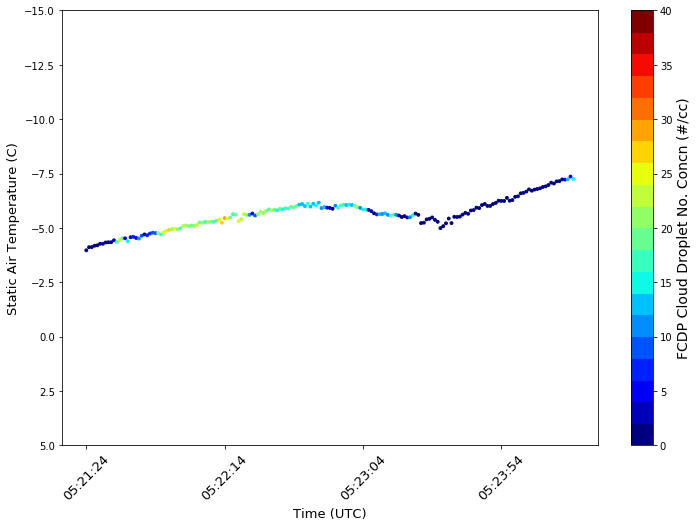

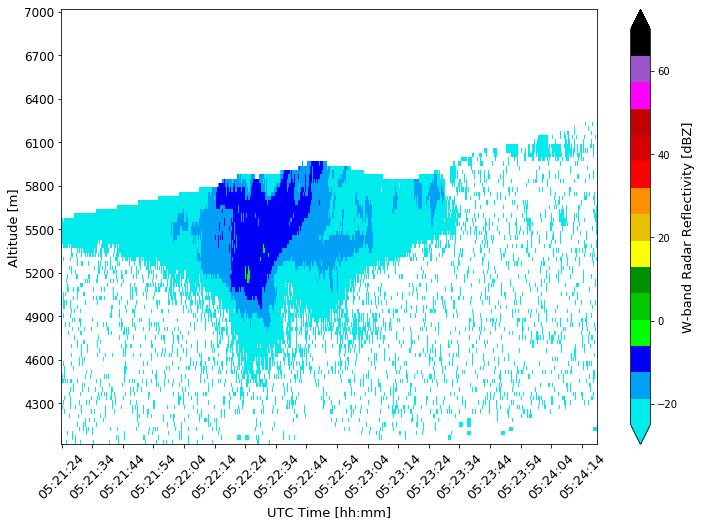

In [5]:
# Grab a particular research flight data and plot T vs Concn data along with Relative Humidty
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.io import netcdf
import math as math
import datetime

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


# Plot CT Air Temperature,Static Air Temp and CDNC vs time for a research flight.

RFn = 7


#fig, ax1 = plt.subplots(figsize=(10,8))

############### Input the timings here ####################
# Required variables : 
month = 9
day = 9
sh = 5
sm = 21
ss = 24
eh = 5
em = 24
es = 20


def time_subset_resample(month,day,sh,sm,ss,eh,em,es): # n = no of sec for resampling
    
    t_start = datetime.datetime(2019,month,day,sh,sm,ss)
    t_end = datetime.datetime(2019,month,day,eh,em,es)
    
    df_P3_sub = df_P3.loc[(df_P3['AC_Time (UTC)'] >= str(t_start)) & (df_P3['AC_Time (UTC)'] <= str(t_end))]
    return df_P3_sub
############################################################################################################

df_P3_sub = time_subset_resample(month,day,sh,sm,ss,eh,em,es)
SAT = df_P3_sub['Static_Air_Temp']
RH = df_P3_sub['Relative_Humidity'] # percent
CDNC = df_P3_sub['conc_LAWSON']/1000 # #/cc
LWC = df_P3_sub['lwc_LAWSON'] # g/m3
Time = df_P3_sub['AC_Time (UTC)']

x_ticks = np.arange(len(Time))
x_labels = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') for ts in Time]
fig = plt.figure(figsize=(12, 8))
cmap=discrete_cmap(20,base_cmap=plt.cm.jet)
plt.scatter(np.arange(df_P3_sub.shape[0]),SAT,s = 8, marker = 'o', 
                     c=CDNC, cmap=cmap, clim=(0.0, 100.0), vmin=0, vmax=40)
cb=plt.colorbar()
cb.set_label('FCDP Cloud Droplet No. Concn (#/cc)', fontsize = 14)
plt.xlabel('Time (UTC)', fontsize=13)
plt.ylabel('Static Air Temperature (C)', fontsize=13)
plt.gca().invert_yaxis()
plt.ylim(5,-15)
plt.gca().set_xticks(x_ticks[::50])
plt.gca().set_xticklabels(x_labels[::50], fontsize=13, rotation=45)
plt.show()

import h5py
import math
import glob
import datetime
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.colors as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from metpy.plots import ctables

def roundup(x):
    for i in range(len(x)):
        x[i] = int(math.ceil(x[i] / 100.0)) * 100 
    return x

ht_gridded = np.linspace(10000.,-5000.,500)
# df = pd.DataFrame(columns=['Lat', 'Lon', 'CTH (km)'])
start = 6500
end = 10000


def grid_altitude(alt3D, W_refl, vel):
    z_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    z_gridded[:,:] = np.nan
    v_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    v_gridded[:,:] = np.nan
    for i in range(np.shape(alt3D)[1]):
        ht = alt3D[:,i]
        z = W_refl[:,i]
        v = vel[:,i]
        for j in range(len(ht)):
            if(np.isnan(z[j])==False and ht[j]>-5000. and ht[j]<10000.):
                m = int((10000.-ht[j])/30.)
                z_gridded[m,i] = z[j]
                v_gridded[m,i] = v[j]
    return z_gridded, v_gridded

# READ AND PARSE HERE
cmap = ctables.registry.get_colortable('NWSReflectivity')

Wn_files = sorted(glob.glob('F:/CAMP2Ex_analysis/DATA/RF07/APR3/*Wn.h5'))
# print(Wn_files[3])
hdf = h5py.File(Wn_files[20],'r')


params_W = hdf['params_W']

hires = hdf['hires']
#print out the variables within geolocation
# for key in hires.keys():
#      print(key)

lat = hires['lat'][0,:]
lon = hires['lon'][0,:]
p_vel = hires['gsp_mps'][0,:]

W_refl = hires['z95n']
# print(W_refl.shape)
W_refl_ = W_refl[:,0,start:end]

vel = hires['vel95n']
vel_ = vel[:,0,start:end]

alt3D = hires['alt3D']
# print(alt3D.shape)
alt3D_ = alt3D[:,0,start:end]
z_gridded, v_gridded = grid_altitude(alt3D_,W_refl_,vel_)

alt_nav = hires['alt_nav'][0,:]

time = hires['scantime']
time = time[:,start:end]
UTC = []
for i in range(time.shape[1]):
    UTC = np.append(UTC,datetime.datetime.utcfromtimestamp(time[0,i]).strftime('%H:%M:%S'))   
# print(UTC[15:45])
plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(z_gridded[100:200,:], cmap=cmap, norm=Normalize(-25,70), interpolation='nearest', aspect='auto')
plt.xlabel('UTC Time [hh:mm]', fontsize=13)
plt.ylabel('Altitude [m]', fontsize=13)
cb = plt.colorbar(orientation='vertical', extend='both')
cb.ax.set_ylabel('W-band Radar Reflectivity [dBZ]', fontsize=13)

# Set the x-ticks to be UTC Time [hh:mm]
x_ticks = np.arange(UTC.shape[0])
x_labels = [timestamps for timestamps in UTC]
ax.set_xticks(x_ticks[::200])
ax.set_xticklabels(x_labels[::200], fontsize=13, rotation=45)

# Set the y-ticks to be height.
vert_vals = ht_gridded[100:200]
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::10])
ax.set_yticklabels(roundup(vert_vals[::10]).astype(int), fontsize=12)

# plt.savefig('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_Wn_Refl_RF07_0558_0600_zoomed.png', 
#             dpi=400, bbox_inches='tight')
plt.show()

In [5]:
import numpy as np
import pandas as pd
import datetime
import glob
import h5py
lst = []
Wn_files = sorted(glob.glob('F:/CAMP2Ex_analysis/DATA/RF07/APR3/*Wn.h5'))
cols = ['Time (1 Hz intervals)', 'Mean valid Z from top 2 gates (dBZ)']
for n_files in range(len(Wn_files)):
    hdf = h5py.File(Wn_files[n_files],'r')
    params_W = hdf['params_W']

    hires = hdf['hires']
    W_refl = hires['z95n']
    W_refl_ = W_refl[:,0,:]
    alt3D = hires['alt3D']
    alt3D_ = alt3D[:,0,:]
    alt_nav = hires['alt_nav'][0,:]

    time = hires['scantime']
    time = time[:,:]
    UTC = []
    for i in range(time.shape[1]):
        UTC = np.append(UTC,datetime.datetime.utcfromtimestamp(time[0,i]).strftime('%H:%M:%S'))
    UTC1 = np.unique(UTC)
    for i in range(len(UTC1)):
        Ze = W_refl_[:,np.where(UTC==UTC1[i])]
        Ze = Ze[np.where(Ze>-30.)]
        if (len(Ze)>0):
            lst.append([UTC1[i], (Ze[0]+Ze[1])/2.])
df = pd.DataFrame(lst, columns=cols)
df.to_csv('F:/CAMP2Ex_analysis/DATA/RF07/APR3/two_gates_Ze.csv', index=False)
df

,Time (1 Hz intervals),Mean valid Z from top 2 gates (dBZ)
0,00:18:51,-6.632868
1,00:18:52,-5.895613
2,00:18:53,-6.309994
3,00:18:54,-5.494394
4,00:18:55,-7.066450
...,...,...
15498,07:52:08,-29.049698
15499,07:52:09,-29.138392
15500,07:52:10,-29.868713
15501,07:52:11,-29.730220


(456, 25, 352)


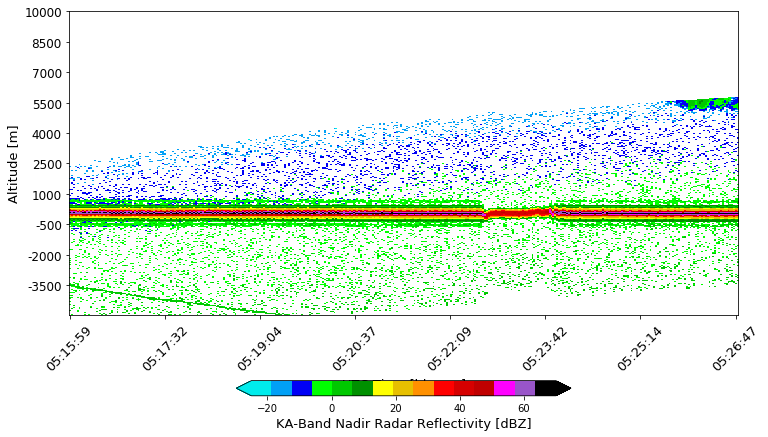

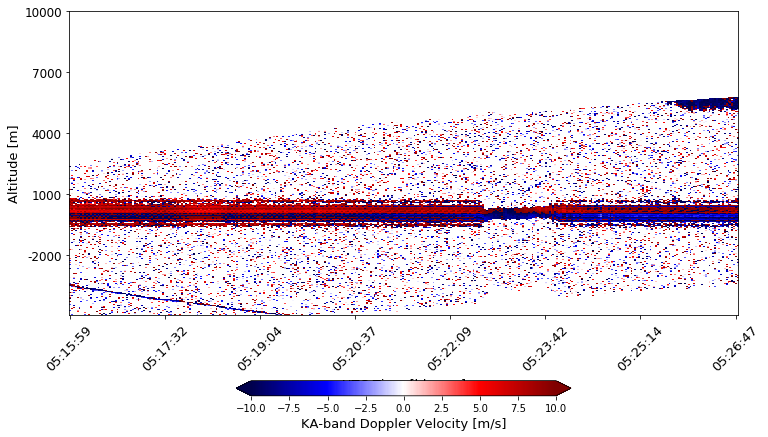

In [16]:
import h5py
import math
import glob
import datetime
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.colors as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from metpy.plots import ctables

def roundup(x):
    for i in range(len(x)):
        x[i] = int(math.ceil(x[i] / 100.0)) * 100 
    return x

ht_gridded = np.linspace(10000.,-5000.,500)
# df = pd.DataFrame(columns=['Lat', 'Lon', 'CTH (km)'])
start = 0
end = 20000


def grid_altitude(alt3D, W_refl, vel):
    z_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    z_gridded[:,:] = np.nan
    v_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    v_gridded[:,:] = np.nan
    for i in range(np.shape(alt3D)[1]):
        ht = alt3D[:,i]
        z = W_refl[:,i]
        v = vel[:,i]
        for j in range(len(ht)):
            if(np.isnan(z[j])==False and ht[j]>-5000. and ht[j]<10000.):
                m = int((10000.-ht[j])/30.)
                z_gridded[m,i] = z[j]
                v_gridded[m,i] = v[j]
    return z_gridded, v_gridded

# READ AND PARSE HERE
cmap = ctables.registry.get_colortable('NWSReflectivity')

Wn_files = sorted(glob.glob('F:/CAMP2Ex_analysis/DATA/RF07/APR3/*KAsWn.h5'))
# print(Wn_files[3])
hdf = h5py.File(Wn_files[12], 'r')

#print out the groups of variables
# print("Keys: %s" % hdf.keys())
# Keys: <KeysViewHDF5 ['hi2lo', 'hires', 'lores', 'params_W', 'postEng_cal']>

params_W = hdf['params_KUKA']
#print out the variables within params_W
# for key in params_W.keys():
#      print(key, params_W[key][:])

hires = hdf['lores']
#print out the variables within geolocation
# for key in hires.keys():
#      print(key)

lat = hires['lat'][0,:]
lon = hires['lon'][0,:]
p_vel = hires['gsp_mps'][0,:]

W_refl = hires['zhh35']
# print(W_refl.shape)
W_refl_ = W_refl[:,12,start:end]

vel = hires['vel35']
vel_ = vel[:,12,start:end]

alt3D = hires['alt3D']
print(alt3D.shape)
alt3D_ = alt3D[:,12,start:end]
z_gridded, v_gridded = grid_altitude(alt3D_,W_refl_,vel_)

alt_nav = hires['alt_nav'][0,:]

time = hires['scantime']
time = time[:,start:end]
UTC = []
for i in range(time.shape[1]):
    UTC = np.append(UTC,datetime.datetime.utcfromtimestamp(time[0,i]).strftime('%H:%M:%S'))

plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(z_gridded, cmap=cmap, norm=Normalize(-25,70), interpolation='nearest', aspect='auto')
plt.xlabel('UTC Time [hh:mm]', fontsize=13)
plt.ylabel('Altitude [m]', fontsize=13)
cb = plt.colorbar(shrink=0.5, orientation='horizontal', pad=0.15, extend='both')
cb.ax.set_xlabel('KA-Band Nadir Radar Reflectivity [dBZ]', fontsize=13)

# Set the x-ticks to be UTC Time [hh:mm]
x_ticks = np.arange(UTC.shape[0])
x_labels = [timestamps for timestamps in UTC]
ax.set_xticks(x_ticks[::50])
ax.set_xticklabels(x_labels[::50], fontsize=13, rotation=45)

# Set the y-ticks to be height.
vert_vals = ht_gridded
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::50])
ax.set_yticklabels(roundup(vert_vals[::50]).astype(int), fontsize=12)

# for i in range(0,np.shape(annot)[0]):
#     if (np.isnan(annot[i,0])==False):
#         plt.annotate('+', xy=(int(annot[i,0]),int(annot[i,1])), color='k', fontsize=12, weight='bold')
plt.savefig('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_Ka_Refl_RF07_0515_0526.png', 
            dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(v_gridded, cmap='seismic', norm=Normalize(-10,10), interpolation='nearest', aspect='auto')
plt.xlabel('UTC Time [hh:mm]', fontsize=13)
plt.ylabel('Altitude [m]', fontsize=13)
cb = plt.colorbar(shrink=0.5, orientation='horizontal', pad=0.15, extend='both')
cb.ax.set_xlabel('KA-band Doppler Velocity [m/s]', fontsize=13)

# Set the x-ticks to be UTC Time [hh:mm]
x_ticks = np.arange(UTC.shape[0])
x_labels = [timestamps for timestamps in UTC]
ax.set_xticks(x_ticks[::50])
ax.set_xticklabels(x_labels[::50], fontsize=13, rotation=45)

# Set the y-ticks to be height.
vert_vals = ht_gridded
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::100])
ax.set_yticklabels(roundup(vert_vals[::100]).astype(int), fontsize=12)

plt.savefig('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_KaRefl_Velocity_RF07_0515_0526.png', 
            dpi=400, bbox_inches='tight')
plt.show()

In [28]:
df.to_csv('F:/CAMP2Ex_analysis/DATA/RF09/APR3/APR3_CTH_1.csv', index=False)

In [ ]:
# def cc_flag(x):
#     if np.isnan(x):
#         cc_flag = 0
#     else:
#         cc_flag = 1
        
#     return cc_flag

# #Calculate physical distance between two geographical coordinates
# def haversine(coord1, coord2):
#     R = 6372800  # Earth radius in meters
#     lat1, lon1 = coord1
#     lat2, lon2 = coord2
#     phi1, phi2 = math.radians(lat1), math.radians(lat2)
#     dphi       = math.radians(lat2 - lat1)
#     dlambda    = math.radians(lon2 - lon1)
#     a = math.sin(dphi/2)**2 + \
#         math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
#     return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

# cols = ['Start_UTC', 'Stop_UTC', 'Start_Lat', 'Stop_Lat','Start_Lon', 'Stop_Lon', 'Along Track Extent (m)',
#         'Clear/Cloud [0/1]', 'Mean CTH (m)', 'SD CTH (m)', 'Mean Plane Altitude (m)', 'Mean Plane Speed (m/s)',
#         'Max Reflectivity (dBZ)', 'Max Doppler Velocity (m/s)']
# lst = []
# i = 0
# j = df.shape[0]
# while i < 10000:
#         cc = cc_flag(df['CTH (m)'][i])
#         start_utc = df['UTC'][i]
#         start_lat = df['Lat'][i]
#         start_lon = df['Lon'][i]
#         start_coord = [start_lat, start_lon]
# #         print(cc,start_utc,start_lat,start_lon)
#         for j in range(i+1, df.shape[0]):
#             if cc_flag(df['CTH (m)'][j]) != cc and (j-i)>=40:
#                 stop_utc = df['UTC'][j]
#                 stop_lat = df['Lat'][j]
#                 stop_lon = df['Lon'][j]
#                 if cc == 1:
#                     mean_cth = np.nanmean(df['CTH (m)'][i:j])
#                     sd_cth = np.nanstd(df['CTH (m)'][i:j])
#                 else:
#                     mean_cth = np.nan
#                     sd_cth = np.nan
#                 mean_nav = np.nanmean(df['Plane_Alt(m)'][i:j])
#                 mean_spd = np.nanmean(df['Plane speed'][i:j])
#                 max_refl = np.nanmax(df['Max Reflectivity'][i:j])
#                 max_dopp = np.nanmax(df['Max Dop Vel'][i:j])
#                 stop_coord = [stop_lat, stop_lon]
#                 extent = haversine(start_coord,stop_coord)
# #                 print(j,stop_lat,stop_lon,mean_cth)
#                 lst.append([start_utc,stop_utc,start_lat,stop_lat,start_lon,stop_lon,extent,cc,mean_cth,
#                                 sd_cth,mean_nav,mean_spd,max_refl,max_dopp])
#                 i = j
#                 break
#             else:
#                 j = j+1
# df1 = pd.DataFrame(lst, columns=cols) 
# df1

## Find clear and cloudy remote-sensing patches from P3 Navigation

In [24]:
import h5py
import math
import glob
import datetime
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.colors as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from metpy.plots import ctables

def roundup(x):
    for i in range(len(x)):
        x[i] = int(math.ceil(x[i] / 100.0)) * 100 
    return x

def grid_altitude(alt3D, W_refl, vel):
    z_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    z_gridded[:,:] = np.nan
    v_gridded = np.zeros((len(ht_gridded),np.shape(alt3D)[1]))
    v_gridded[:,:] = np.nan
    for i in range(np.shape(alt3D)[1]):
        ht = alt3D[:,i]
        z = W_refl[:,i]
        v = vel[:,i]
        for j in range(len(ht)):
            if(np.isnan(z[j])==False and ht[j]>-5000. and ht[j]<10000.):
                m = int((10000.-ht[j])/30.)
                z_gridded[m,i] = z[j]
                v_gridded[m,i] = v[j]
    return z_gridded, v_gridded

def cc_flag(x):
    if np.isnan(x):
        cc_flag = 0
    else:
        cc_flag = 1
        
    return cc_flag

#Calculate physical distance between two geographical coordinates
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

Wn_files = sorted(glob.glob('F:/CAMP2Ex_analysis/DATA/RF07/APR3/*Wn.h5'))
# print(Wn_files[3])
# hdf = h5py.File(Wn_files[1], 'r')

#print out the groups of variables
# print("Keys: %s" % hdf.keys())
# Keys: <KeysViewHDF5 ['hi2lo', 'hires', 'lores', 'params_W', 'postEng_cal']>
cols = ['UTC', 'Lat', 'Lon', 'Plane speed', 'CTH (m)', 'Plane_Alt(m)', 'Mean Reflectivity', 'Mean Dop Vel']
ht_gridded = np.linspace(10000.,-5000.,500)
# df = pd.DataFrame(columns=['Lat', 'Lon', 'CTH (km)'])
start = 0
end = 20000

def file_data(hdf):
    ht_gridded = np.linspace(10000.,-5000.,500)
#     start = 0
#     end = 16576
    params_W = hdf['params_W']
    #print out the variables within params_W
    # for key in params_W.keys():
    #      print(key, params_W[key][:])

    hires = hdf['hires']
    #print out the variables within geolocation
    # for key in hires.keys():
    #      print(key)

    lat = hires['lat'][0,:]
    lon = hires['lon'][0,:]
    p_vel = hires['gsp_mps'][0,:]

    W_refl = hires['z95n']
    # print(W_refl.shape)
    W_refl_ = W_refl[:,0,start:end]

    vel = hires['vel95n']
    vel_ = vel[:,0,start:end]

    alt3D = hires['alt3D']
    print('Number of scans : '+str(alt3D.shape[2]))
    alt3D_ = alt3D[:,0,start:end]
    z_gridded, v_gridded = grid_altitude(alt3D_,W_refl_,vel_)

    alt_nav = hires['alt_nav'][0,:]

    time = hires['scantime']
    time = time[:,start:end]
    UTC = []
    for i in range(time.shape[1]):
        UTC = np.append(UTC,datetime.datetime.utcfromtimestamp(time[0,i]).strftime('%H:%M:%S'))

    annot = np.zeros((len(lat),2))
    lst = []
    z_gridded = z_gridded[np.where(np.logical_and(ht_gridded>-500.,ht_gridded<8000.))[0][:],:]
    v_gridded = v_gridded[np.where(np.logical_and(ht_gridded>-500.,ht_gridded<8000.))[0][:],:]
    ht_gridded = ht_gridded[np.where(np.logical_and(ht_gridded>-500.,ht_gridded<8000.))[0][:]]
    for shot in range(len(lat)-1):
        try:
            z2 = z_gridded[np.isnan(z_gridded[:,shot])==False,shot] 
            v2 = v_gridded[np.isnan(z_gridded[:,shot])==False,shot]
            ht2 = ht_gridded[np.isnan(z_gridded[:,shot])==False] 
            cth = ht2[np.where(z2>-10.)][0]
            if (alt_nav[shot]-cth>500.):
                if (cth>1000.):
        #                 print(shot, cth )
                        annot[shot,0] = shot
                        annot[shot,1] = np.where(abs(ht_gridded-cth)==np.min(abs(ht_gridded-cth)))[0]
                        lst.append([UTC[shot], lat[shot], lon[shot], p_vel[shot], cth, alt_nav[shot],
                                   np.nanmean(z2[np.where(ht2>1000.)]), np.nanmean(v2[np.where(ht2>1000.)])])
                else:
                        annot[shot,:] = np.nan
                        lst.append([UTC[shot], lat[shot], lon[shot], p_vel[shot], np.nan, alt_nav[shot], np.nan, np.nan])
            else:
                annot[shot,:] = np.nan
                lst.append([UTC[shot], lat[shot], lon[shot], p_vel[shot], np.nan, alt_nav[shot], np.nan, np.nan])
        except:
            continue
    return lst

df = pd.DataFrame(columns=cols)
for i in range(0,len(Wn_files)):
    print(Wn_files[i])
    hdf = h5py.File(Wn_files[i], 'r')
    lst = file_data(hdf)
    df_ = pd.DataFrame(lst, columns=cols)
    df = pd.concat([df,df_])


cols = ['Start_UTC', 'Stop_UTC', 'Start_Lat', 'Stop_Lat','Start_Lon', 'Stop_Lon', 'Along Track Extent (m)',
        'Clear/Cloud [0/1]', 'Mean CTH (m)', 'SD CTH (m)', 'Mean Plane Altitude (m)', 'Mean Plane Speed (m/s)',
        'Max Reflectivity (dBZ)', 'Max Doppler Velocity (m/s)']
lst = []
i = 0
j = df.shape[0]
while i < df.shape[0]-100:
        cc = cc_flag(df['CTH (m)'].values[i])
        start_utc = df['UTC'].values[i]
        start_lat = df['Lat'].values[i]
        start_lon = df['Lon'].values[i]
        start_coord = [start_lat, start_lon]
#         print(cc,start_utc,start_lat,start_lon)
        for j in range(i+1, df.shape[0]):
            if cc_flag(df['CTH (m)'].values[j]) != cc and (j-i)>=40:
                stop_utc = df['UTC'].values[j]
                stop_lat = df['Lat'].values[j]
                stop_lon = df['Lon'].values[j]
                if cc == 1:
                    mean_cth = np.nanmean(df['CTH (m)'].values[i:j])
                    sd_cth = np.nanstd(df['CTH (m)'].values[i:j])
                    max_refl = np.nanmax(df['Mean Reflectivity'].values[i:j])
                    max_dopp = np.nanmax(df['Mean Dop Vel'].values[i:j])
                else:
                    mean_cth = np.nan
                    sd_cth = np.nan
                    max_refl = np.nan
                    max_dopp = np.nan
                mean_nav = np.nanmean(df['Plane_Alt(m)'].values[i:j])
                mean_spd = np.nanmean(df['Plane speed'].values[i:j])
                stop_coord = [stop_lat, stop_lon]
                extent = haversine(start_coord,stop_coord)
                lst.append([start_utc,stop_utc,start_lat,stop_lat,start_lon,stop_lon,extent,cc,mean_cth,
                                sd_cth,mean_nav,mean_spd,max_refl,max_dopp])
                i = j
                break
            else:
                j = j+1
                
        if (df.shape[0]-100-j<100):
            break
                
df1 = pd.DataFrame(lst, columns=cols) 
df1 = df1.drop(np.where(df1['Along Track Extent (m)'].values>80000.)[0][:])
df1.to_csv('F:/CAMP2Ex_analysis/DATA/RF07/APR3/APR3_Cloud_Clear_Patches_RF07.csv', index=False)

F:/CAMP2Ex_analysis/DATA/RF07/APR3\CAMP2Ex-APR3-L2ZV_P3B_20190908_R0_S20190909a001851_E20190909a002355_KUsKAsWn.h5
Number of scans : 6076
F:/CAMP2Ex_analysis/DATA/RF07/APR3\CAMP2Ex-APR3-L2ZV_P3B_20190908_R0_S20190909a002608_E20190909a003754_KUsKAsWn.h5
Number of scans : 14101
F:/CAMP2Ex_analysis/DATA/RF07/APR3\CAMP2Ex-APR3-L2ZV_P3B_20190908_R0_S20190909a003810_E20190909a004557_KUsKAsWn.h5
Number of scans : 9352
F:/CAMP2Ex_analysis/DATA/RF07/APR3\CAMP2Ex-APR3-L2ZV_P3B_20190908_R0_S20190909a010225_E20190909a010243_Wn.h5
Number of scans : 576
F:/CAMP2Ex_analysis/DATA/RF07/APR3\CAMP2Ex-APR3-L2ZV_P3B_20190908_R0_S20190909a012429_E20190909a013621_KUsKAsWn.h5
Number of scans : 14201
F:/CAMP2Ex_analysis/DATA/RF07/APR3\CAMP2Ex-APR3-L2ZV_P3B_20190908_R0_S20190909a013631_E20190909a014820_KUsKAsWn.h5
Number of scans : 14176
F:/CAMP2Ex_analysis/DATA/RF07/APR3\CAMP2Ex-APR3-L2ZV_P3B_20190908_R0_S20190909a014832_E20190909a020020_KUsKAsWn.h5
Number of scans : 14151
F:/CAMP2Ex_analysis/DATA/RF07/APR3\CA

In [ ]:
# df1 = df1.drop(np.where(df1['Along Track Extent (m)'].values>80000.)[0][:])
plt.hist(df1['Along Track Extent (m)'],edgecolor='k',linewidth=1.2)
plt.show()

In [25]:
df1

,Start_UTC,Stop_UTC,Start_Lat,Stop_Lat,Start_Lon,Stop_Lon,Along Track Extent (m),Clear/Cloud [0/1],Mean CTH (m),SD CTH (m),Mean Plane Altitude (m),Mean Plane Speed (m/s),Max Reflectivity (dBZ),Max Doppler Velocity (m/s)
0,00:18:51,00:19:56,15.823375,15.863778,121.627374,121.698869,8872.285303,0,NaN,NaN,5022.973784,137.392552,NaN,NaN
1,00:19:56,00:19:58,15.863778,15.865074,121.698869,121.701125,281.104676,1,4347.115283,237.590813,5080.650913,137.040737,4.482952,0.545308
2,00:19:58,00:20:00,15.865074,15.866320,121.701125,121.703299,270.761325,0,NaN,NaN,5084.299597,137.000000,NaN,NaN
3,00:20:00,00:20:02,15.866320,15.867630,121.703299,121.705584,284.636737,1,4336.673347,225.430861,5088.936998,137.000000,4.120612,-0.061759
5,00:43:02,00:43:04,17.289216,17.292473,122.779595,122.779651,362.304963,1,4889.779559,0.000000,5809.000000,180.400000,-20.619116,0.625350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,07:39:19,07:39:22,17.033476,17.032715,125.198826,125.193971,523.254081,0,NaN,NaN,6167.604756,171.613570,NaN,NaN
1643,07:39:22,07:39:27,17.032715,17.031492,125.193971,125.186231,834.215930,1,4691.964574,14.833272,6139.628230,172.125598,-6.551546,1.507586
1644,07:39:27,07:39:29,17.031492,17.030987,125.186231,125.183037,344.387273,0,NaN,NaN,6115.232600,172.441860,NaN,NaN
1645,07:39:29,07:39:34,17.030987,17.029729,125.183037,125.175030,862.911652,1,4941.182365,52.634404,6090.776396,172.717984,-13.875753,0.181894
